Linear Interpolation - Polynomial Interpolation (order = 2) - Polynomial Interpolation (order = 3) - Dropping - Fill as zero - Fill using KNN (K = 3)

# Import Packages

In [1]:
#Importing Required Libraries
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import tensorflow as tf
from sklearn.impute import KNNImputer



# Upload Datasets

We remove the outliers detected from the preliminary analysis. Readings above 10000 ppm and below 50 ppm are considered outliers based on the WHO Co2 range indoors. We assume those readings to be a failed transmission.

In [2]:
df = pd.read_csv("DEV_1.csv")
df[df > 10000] = 0
df[df < 50] = 0
df.head()

,Co2
0,629
1,623
2,613
3,638
4,621


In [3]:
df_failure = df.replace(0, np.nan) # Replace missing value with nan
df_failure.head()

,Co2
0,629.0
1,623.0
2,613.0
3,638.0
4,621.0


# Linear Interpolation

In [4]:
df_linear = df_failure.interpolate()

In [5]:
# Preprocessing
# Normaliztion
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_linear)
data_n = pd.DataFrame(np_scaled)


# Important parameters and training/Test size
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

# Training data
x_train = data_n[0:-1-testdatacut].values
y_train = data_n[1:-testdatacut].values

# Test data
x_test = data_n[0-testdatacut:-1].values
y_test = data_n[1-testdatacut:].values

def unroll(data,sequence_length=50):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]



In [6]:
# Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (18778, 50, 1)
y_train (18778, 1)
x_test (1000, 50, 1)
y_test (1000, 1)


In [7]:
model_linear = Sequential()

model_linear.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# model_linear.add(Dropout(0.2))
model_linear.add(LSTM(128, return_sequences=True))
# model_linear.add(Dropout(0.2))
model_linear.add(LSTM(64, return_sequences=True))
# model_linear.add(Dropout(0.2))
model_linear.add(LSTM(64, return_sequences=True))
# model_linear.add(Dropout(0.2))
model_linear.add(LSTM(32, return_sequences=False))
# model_linear.add(Dropout(0.2))

model_linear.add(Dense(1))

start = time.time()
model_linear.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.011627674102783203


In [8]:
with tf.device('/gpu:0'):
  model_linear.fit(x_train, y_train, batch_size=50, epochs =40, validation_split=0.1)

Epoch 1/40
338/338 [==============================] - 148s 409ms/step - loss: 0.2994 - val_loss: 0.2307
Epoch 2/40
338/338 [==============================] - 137s 406ms/step - loss: 0.2428 - val_loss: 0.2392
Epoch 3/40
338/338 [==============================] - 137s 406ms/step - loss: 0.2353 - val_loss: 0.2217
Epoch 4/40
338/338 [==============================] - 136s 401ms/step - loss: 0.2346 - val_loss: 0.2246
Epoch 5/40
338/338 [==============================] - 136s 402ms/step - loss: 0.2307 - val_loss: 0.2272
Epoch 6/40
338/338 [==============================] - 138s 408ms/step - loss: 0.2313 - val_loss: 0.2207
Epoch 7/40
338/338 [==============================] - 134s 398ms/step - loss: 0.2286 - val_loss: 0.2230
Epoch 8/40
338/338 [==============================] - 136s 401ms/step - loss: 0.2283 - val_loss: 0.2254
Epoch 9/40
338/338 [==============================] - 132s 392ms/step - loss: 0.2272 - val_loss: 0.2229
Epoch 10/40
338/338 [==============================] - 133s 394m

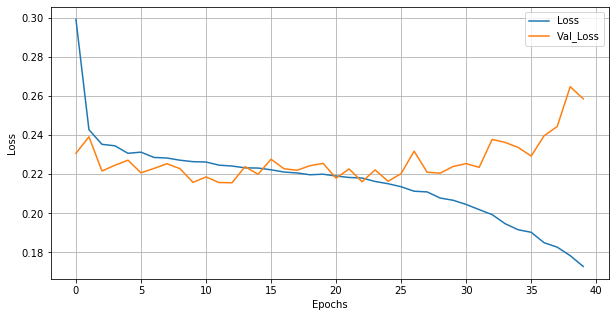

In [9]:
plt.figure(figsize = (10, 5))
plt.plot(model_linear.history.history['loss'], label = 'Loss')
plt.plot(model_linear.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('Loss.png')
plt.show()

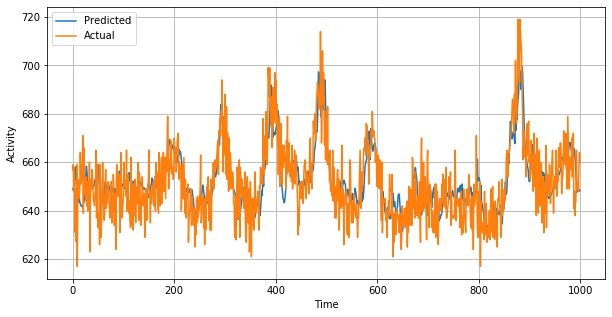

In [10]:
# Postprocessing
loaded_model_linear = model_linear

p_linear = loaded_model_linear.predict(x_test)

Pred_linear = min_max_scaler.inverse_transform(np.array(p_linear))
Actual_linear = min_max_scaler.inverse_transform(np.array(y_test))

plt.figure(figsize = (10, 5))
plt.plot(Pred_linear, label = 'Predicted')
plt.plot(Actual_linear, Label = 'Actual')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid()
plt.legend()
plt.savefig('Activation.png')
plt.show()

In [11]:
RMSE_linear = np.sqrt(np.mean((Actual_linear-Pred_linear)**2))
print(RMSE_linear)

10.527868077457141


# Polynomial Interpolation (order = 2)

In [12]:
df_poly_2 = df_failure.interpolate(method="polynomial", order=2)

In [13]:
# Preprocessing
# Normaliztion
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_poly_2)
data_n = pd.DataFrame(np_scaled)


# Important parameters and training/Test size
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

# Training data
x_train = data_n[0:-1-testdatacut].values
y_train = data_n[1:-testdatacut].values

# Test data
x_test = data_n[0-testdatacut:-1].values
y_test = data_n[1-testdatacut:].values

def unroll(data,sequence_length=50):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]



In [14]:
model_poly_2 = Sequential()

model_poly_2.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_poly_2.add(Dropout(0.2))
model_poly_2.add(LSTM(128, return_sequences=True))
model_poly_2.add(Dropout(0.2))
model_poly_2.add(LSTM(64, return_sequences=True))
# model_poly_2.add(Dropout(0.2))
model_poly_2.add(LSTM(64, return_sequences=True))
# model_poly_2.add(Dropout(0.2))
model_poly_2.add(LSTM(32, return_sequences=False))
# model_poly_2.add(Dropout(0.2))

model_poly_2.add(Dense(1))

start = time.time()
model_poly_2.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.005499839782714844


In [15]:
with tf.device('/gpu:0'):
  model_poly_2.fit(x_train, y_train, batch_size=50, epochs =40, validation_split=0.1)

Epoch 1/40
338/338 [==============================] - 146s 406ms/step - loss: 0.0543 - val_loss: 0.0105
Epoch 2/40
338/338 [==============================] - 135s 399ms/step - loss: 0.0189 - val_loss: 0.0059
Epoch 3/40
338/338 [==============================] - 133s 393ms/step - loss: 0.0135 - val_loss: 0.0025
Epoch 4/40
338/338 [==============================] - 135s 400ms/step - loss: 0.0112 - val_loss: 0.0045
Epoch 5/40
338/338 [==============================] - 133s 394ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 6/40
338/338 [==============================] - 130s 386ms/step - loss: 0.0088 - val_loss: 0.0022
Epoch 7/40
338/338 [==============================] - 133s 393ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 8/40
338/338 [==============================] - 135s 399ms/step - loss: 0.0076 - val_loss: 0.0022
Epoch 9/40
338/338 [==============================] - 132s 390ms/step - loss: 0.0079 - val_loss: 0.0020
Epoch 10/40
338/338 [==============================] - 134s 397m

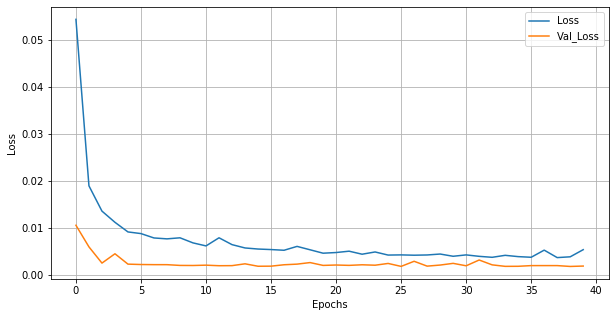

In [16]:
plt.figure(figsize = (10, 5))
plt.plot(model_poly_2.history.history['loss'], label = 'Loss')
plt.plot(model_poly_2.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('Loss.png')
plt.show()

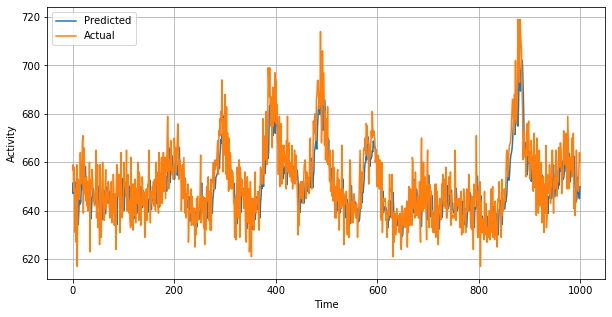

In [17]:
# Postprocessing
loaded_model_poly_2 = model_poly_2

p_poly_2 = loaded_model_poly_2.predict(x_test)

Pred_poly_2 = min_max_scaler.inverse_transform(np.array(p_poly_2))
Actual_poly_2 = min_max_scaler.inverse_transform(np.array(y_test))

plt.figure(figsize = (10, 5))
plt.plot(Pred_poly_2, label = 'Predicted')
plt.plot(Actual_poly_2, Label = 'Actual')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid()
plt.legend()
plt.savefig('Activation.png')
plt.show()

In [18]:
RMSE_poly_2 = np.sqrt(np.mean((Actual_poly_2-Pred_poly_2)**2))
print(RMSE_poly_2)

10.519746858321104


# Polynomial Interpolation (order = 3)

In [19]:
df_poly_3 = df_failure.interpolate(method="polynomial", order=3)

In [20]:
# Preprocessing
# Normaliztion
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_poly_3)
data_n = pd.DataFrame(np_scaled)


# Important parameters and training/Test size
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

# Training data
x_train = data_n[0:-1-testdatacut].values
y_train = data_n[1:-testdatacut].values

# Test data
x_test = data_n[0-testdatacut:-1].values
y_test = data_n[1-testdatacut:].values

def unroll(data,sequence_length=50):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]



In [21]:
model_poly_3 = Sequential()

model_poly_3.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model_poly_3.add(Dropout(0.2))
model_poly_3.add(LSTM(128, return_sequences=True))
model_poly_3.add(Dropout(0.2))
model_poly_3.add(LSTM(64, return_sequences=True))
# model_poly_3.add(Dropout(0.2))
model_poly_3.add(LSTM(64, return_sequences=True))
# model_poly_3.add(Dropout(0.2))
model_poly_3.add(LSTM(32, return_sequences=False))
# model_poly_3.add(Dropout(0.2))

model_poly_3.add(Dense(1))

start = time.time()
model_poly_3.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.003917217254638672


In [22]:
with tf.device('/gpu:0'):
  model_poly_3.fit(x_train, y_train, batch_size=50, epochs =40, validation_split=0.1)

Epoch 1/40
338/338 [==============================] - 144s 402ms/step - loss: 0.0585 - val_loss: 0.0030
Epoch 2/40
338/338 [==============================] - 135s 399ms/step - loss: 0.0188 - val_loss: 0.0037
Epoch 3/40
338/338 [==============================] - 137s 405ms/step - loss: 0.0128 - val_loss: 0.0025
Epoch 4/40
338/338 [==============================] - 136s 402ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 5/40
338/338 [==============================] - 136s 402ms/step - loss: 0.0090 - val_loss: 0.0024
Epoch 6/40
338/338 [==============================] - 134s 398ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 7/40
338/338 [==============================] - 134s 397ms/step - loss: 0.0080 - val_loss: 0.0024
Epoch 8/40
338/338 [==============================] - 133s 394ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 9/40
338/338 [==============================] - 139s 411ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 10/40
338/338 [==============================] - 138s 408m

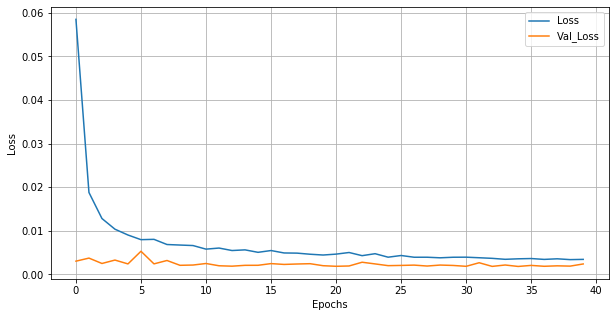

In [23]:
plt.figure(figsize = (10, 5))
plt.plot(model_poly_3.history.history['loss'], label = 'Loss')
plt.plot(model_poly_3.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('Loss.png')
plt.show()

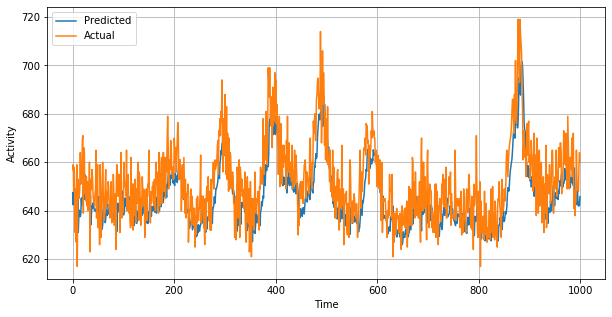

In [24]:
# Postprocessing
loaded_model_poly_3 = model_poly_3

p_poly_3 = loaded_model_poly_3.predict(x_test)

Pred_poly_3 = min_max_scaler.inverse_transform(np.array(p_poly_3))
Actual_poly_3 = min_max_scaler.inverse_transform(np.array(y_test))

plt.figure(figsize = (10, 5))
plt.plot(Pred_poly_3, label = 'Predicted')
plt.plot(Actual_poly_3, Label = 'Actual')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid()
plt.legend()
plt.savefig('Activation.png')
plt.show()

In [25]:
RMSE_poly_3 = np.sqrt(np.mean((Actual_poly_3-Pred_poly_3)**2))
print(RMSE_poly_3)

12.011065223961351


# Dropping

In [26]:
df_Drop = df_failure.dropna()

In [27]:
# Preprocessing
# Normaliztion
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_Drop)
data_n = pd.DataFrame(np_scaled)


# Important parameters and training/Test size
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

# Training data
x_train = data_n[0:-1-testdatacut].values
y_train = data_n[1:-testdatacut].values

# Test data
x_test = data_n[0-testdatacut:-1].values
y_test = data_n[1-testdatacut:].values

def unroll(data,sequence_length=50):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]



In [28]:
model_Drop = Sequential()

model_Drop.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# model_Drop.add(Dropout(0.2))
model_Drop.add(LSTM(128, return_sequences=True))
# model_Drop.add(Dropout(0.2))
model_Drop.add(LSTM(64, return_sequences=True))
# model_Drop.add(Dropout(0.2))
model_Drop.add(LSTM(64, return_sequences=True))
# model_Drop.add(Dropout(0.2))
model_Drop.add(LSTM(32, return_sequences=False))
# model_Drop.add(Dropout(0.2))

model_Drop.add(Dense(1))

start = time.time()
model_Drop.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.004790306091308594


In [29]:
with tf.device('/gpu:0'):
  model_Drop.fit(x_train, y_train, batch_size=50, epochs =40, validation_split=0.1)

Epoch 1/40
253/253 [==============================] - 244s 908ms/step - loss: 0.3851 - val_loss: 0.3121
Epoch 2/40
253/253 [==============================] - 225s 888ms/step - loss: 0.3068 - val_loss: 0.3691
Epoch 3/40
253/253 [==============================] - 230s 909ms/step - loss: 0.3004 - val_loss: 0.3086
Epoch 4/40
253/253 [==============================] - 232s 917ms/step - loss: 0.2942 - val_loss: 0.4392
Epoch 5/40
253/253 [==============================] - 224s 885ms/step - loss: 0.2949 - val_loss: 0.3045
Epoch 6/40
253/253 [==============================] - 222s 876ms/step - loss: 0.2922 - val_loss: 0.2934
Epoch 7/40
253/253 [==============================] - 223s 881ms/step - loss: 0.2918 - val_loss: 0.3350
Epoch 8/40
253/253 [==============================] - 225s 890ms/step - loss: 0.2897 - val_loss: 0.2859
Epoch 9/40
253/253 [==============================] - 232s 917ms/step - loss: 0.2878 - val_loss: 0.3245
Epoch 10/40
253/253 [==============================] - 226s 893m

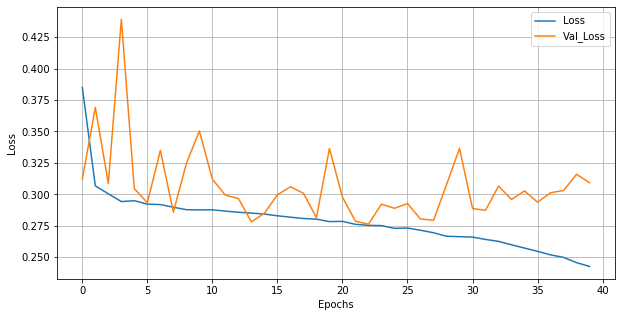

In [30]:
plt.figure(figsize = (10, 5))
plt.plot(model_Drop.history.history['loss'], label = 'Loss')
plt.plot(model_Drop.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('Loss.png')
plt.show()

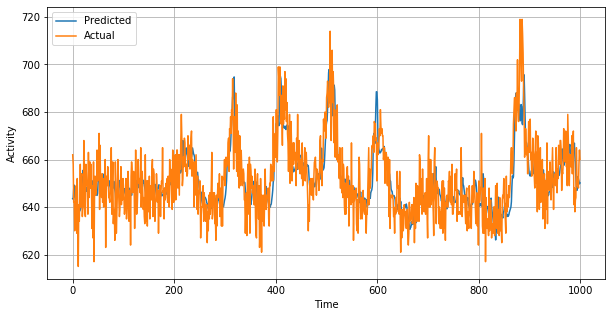

In [31]:
# Postprocessing
loaded_model_Drop = model_Drop

p_Drop = loaded_model_Drop.predict(x_test)

Pred_Drop = min_max_scaler.inverse_transform(np.array(p_Drop))
Actual_Drop = min_max_scaler.inverse_transform(np.array(y_test))

plt.figure(figsize = (10, 5))
plt.plot(Pred_Drop, label = 'Predicted')
plt.plot(Actual_Drop, Label = 'Actual')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid()
plt.legend()
plt.savefig('Activation.png')
plt.show()

In [32]:
RMSE_Drop = np.sqrt(np.mean((Actual_Drop-Pred_Drop)**2))
print(RMSE_Drop)

10.510283509249762


# Keep 0 

In [33]:
df_zero = df

In [34]:
# Preprocessing
# Normaliztion
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_zero)
data_n = pd.DataFrame(np_scaled)


# Important parameters and training/Test size
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

# Training data
x_train = data_n[0:-1-testdatacut].values
y_train = data_n[1:-testdatacut].values

# Test data
x_test = data_n[0-testdatacut:-1].values
y_test = data_n[1-testdatacut:].values

def unroll(data,sequence_length=50):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]



In [35]:
model_zero = Sequential()

model_zero.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# model_zero.add(Dropout(0.2))
model_zero.add(LSTM(128, return_sequences=True))
# model_zero.add(Dropout(0.2))
model_zero.add(LSTM(64, return_sequences=True))
# model_zero.add(Dropout(0.2))
model_zero.add(LSTM(64, return_sequences=True))
# model_zero.add(Dropout(0.2))
model_zero.add(LSTM(32, return_sequences=False))
# model_zero.add(Dropout(0.2))

model_zero.add(Dense(1))

start = time.time()
model_zero.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.0051860809326171875


In [36]:
with tf.device('/gpu:0'):
  model_zero.fit(x_train, y_train, batch_size=50, epochs =40, validation_split=0.1)

Epoch 1/40
338/338 [==============================] - 143s 401ms/step - loss: 0.5300 - val_loss: 1.0442
Epoch 2/40
338/338 [==============================] - 134s 396ms/step - loss: 0.5015 - val_loss: 1.0951
Epoch 3/40
338/338 [==============================] - 130s 386ms/step - loss: 0.4962 - val_loss: 1.0524
Epoch 4/40
338/338 [==============================] - 130s 385ms/step - loss: 0.4911 - val_loss: 1.0510
Epoch 5/40
338/338 [==============================] - 135s 399ms/step - loss: 0.4905 - val_loss: 1.0418
Epoch 6/40
338/338 [==============================] - 131s 388ms/step - loss: 0.4874 - val_loss: 1.0442
Epoch 7/40
338/338 [==============================] - 136s 404ms/step - loss: 0.4851 - val_loss: 1.0515
Epoch 8/40
338/338 [==============================] - 131s 388ms/step - loss: 0.4889 - val_loss: 1.0359
Epoch 9/40
338/338 [==============================] - 130s 384ms/step - loss: 0.4839 - val_loss: 1.0574
Epoch 10/40
338/338 [==============================] - 130s 385m

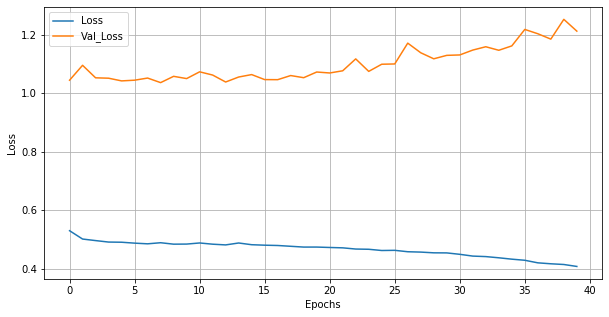

In [37]:
plt.figure(figsize = (10, 5))
plt.plot(model_zero.history.history['loss'], label = 'Loss')
plt.plot(model_zero.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('Loss.png')
plt.show()

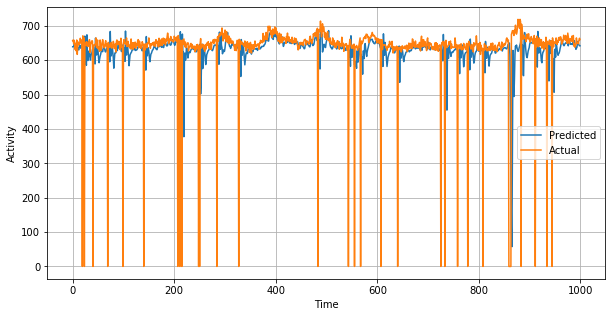

In [38]:
# Postprocessing
loaded_model_zero = model_zero

p_zero = loaded_model_zero.predict(x_test)

Pred_zero = min_max_scaler.inverse_transform(np.array(p_zero))
Actual_zero = min_max_scaler.inverse_transform(np.array(y_test))

plt.figure(figsize = (10, 5))
plt.plot(Pred_zero, label = 'Predicted')
plt.plot(Actual_zero, Label = 'Actual')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid()
plt.legend()
plt.savefig('Activation.png')
plt.show()

In [39]:
RMSE_zero = np.sqrt(np.mean((Actual_zero-Pred_zero)**2))
print(RMSE_zero)

119.960262722175


# KNN (K = 3)

In [40]:
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df_failure)
df_K_3 = pd.DataFrame(imputed, columns=df_failure.columns)

In [41]:
# Preprocessing
# Normaliztion
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_K_3)
data_n = pd.DataFrame(np_scaled)


# Important parameters and training/Test size
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length + 1

# Training data
x_train = data_n[0:-1-testdatacut].values
y_train = data_n[1:-testdatacut].values

# Test data
x_test = data_n[0-testdatacut:-1].values
y_test = data_n[1-testdatacut:].values

def unroll(data,sequence_length=50):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]



In [42]:
model_K_3 = Sequential()

model_K_3.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
# model_K_3.add(Dropout(0.2))
model_K_3.add(LSTM(128, return_sequences=True))
# model_K_3.add(Dropout(0.2))
model_K_3.add(LSTM(64, return_sequences=True))
# model_K_3.add(Dropout(0.2))
model_K_3.add(LSTM(64, return_sequences=True))
# model_K_3.add(Dropout(0.2))
model_K_3.add(LSTM(32, return_sequences=False))
# model_K_3.add(Dropout(0.2))

model_K_3.add(Dense(1))

start = time.time()
model_K_3.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.003543853759765625


In [43]:
with tf.device('/gpu:0'):
  model_K_3.fit(x_train, y_train, batch_size=50, epochs =40, validation_split=0.1)

Epoch 1/40
338/338 [==============================] - 143s 396ms/step - loss: 0.4206 - val_loss: 0.4197
Epoch 2/40
338/338 [==============================] - 130s 385ms/step - loss: 0.3681 - val_loss: 0.3759
Epoch 3/40
338/338 [==============================] - 130s 384ms/step - loss: 0.3611 - val_loss: 0.3887
Epoch 4/40
338/338 [==============================] - 131s 386ms/step - loss: 0.3619 - val_loss: 0.3952
Epoch 5/40
338/338 [==============================] - 134s 397ms/step - loss: 0.3588 - val_loss: 0.3793
Epoch 6/40
338/338 [==============================] - 131s 387ms/step - loss: 0.3550 - val_loss: 0.3767
Epoch 7/40
338/338 [==============================] - 132s 390ms/step - loss: 0.3548 - val_loss: 0.3795
Epoch 8/40
338/338 [==============================] - 136s 403ms/step - loss: 0.3544 - val_loss: 0.3709
Epoch 9/40
338/338 [==============================] - 132s 391ms/step - loss: 0.3521 - val_loss: 0.3872
Epoch 10/40
338/338 [==============================] - 132s 392m

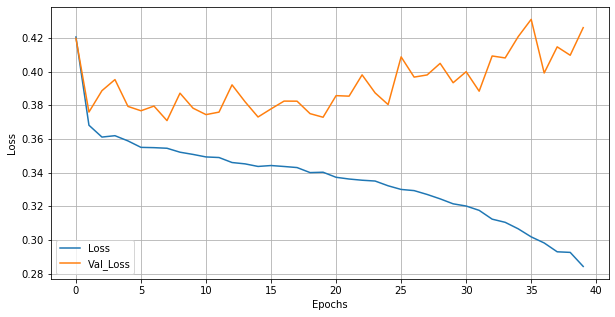

In [44]:
plt.figure(figsize = (10, 5))
plt.plot(model_K_3.history.history['loss'], label = 'Loss')
plt.plot(model_K_3.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.savefig('Loss.png')
plt.show()

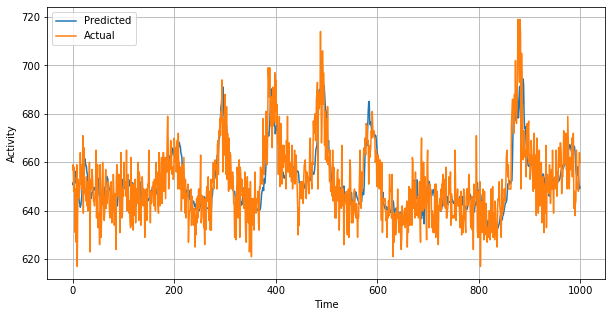

In [45]:
# Postprocessing
loaded_model_K_3 = model_K_3

p_K_3 = loaded_model_K_3.predict(x_test)

Pred_K_3 = min_max_scaler.inverse_transform(np.array(p_K_3))
Actual_K_3 = min_max_scaler.inverse_transform(np.array(y_test))

plt.figure(figsize = (10, 5))
plt.plot(Pred_K_3, label = 'Predicted')
plt.plot(Actual_K_3, Label = 'Actual')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid()
plt.legend()
plt.savefig('Activation.png')
plt.show()

In [46]:
RMSE_K_3 = np.sqrt(np.mean((Actual_K_3-Pred_K_3)**2))
print(RMSE_K_3)

10.522830886510992


We can notice that linear interpolation and KNN interpolation are the best in terms of RMSE of the future prediction of the Co2 readings. We use LSTM architecture to forecast the future readings. This device has low error rate in terms of failed transmission. Therefore, dropping the failed transmissions instead of interpolating them still gives good results. However, second order and third order polynomial, and using zero values for the failed transmissions are considered the worst ways to handle the missing values. In addition, dropping the failed transmissions completely in devices that have high error rate in terms of failed transmission gives unstable and bad results in terms of RMSE.

Therefore, linear interpolation is more stable, simple and can be generalized over all the devices.